## Training

In [16]:
import os
import gdown
import pickle
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, clear_output
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

from functions import crism_to_mat, filter_bad_pixels, remove_spikes_column

In [2]:
# def create_image_paths(directory_path):
#     image_paths = {}
#     for root, dirs, files in os.walk(directory_path):
#         for file in files:
#             if file.lower().endswith('.hdr'):
#                 id = file[6:11]
#                 image_paths[id] = os.path.join(root, file)
#     return image_paths

In [3]:
# exclude = ['02885', '07E26', '0B385', '0C26C', '03E12', '082EE', '064D9', '08F68', \
#            '0A91C', '0B252', '098B2', '13F5B', '09C0A', '0CA5C', '09326', '0ABCB', \
#            '03BFB', '0634B', '0454E', '0A425', '09365', '09D44', '0634B', '0A546', \
#            '050F2', '03E12', '0A546', '09312', '0CBE5', '09312', '0AB81', '0AA7D', \
#            '040FF', '09E4C', '0A425']

In [4]:
# # Load .mat file
# data_a = scipy.io.loadmat('datasets/CRISM_bland_unratioed.mat')
# data_b = scipy.io.loadmat('datasets/CRISM_labeled_pixels_ratioed.mat')

# im_names_a = []                               # list of CRISM image names, mapping to numerical ID
# for id in data_a['im_names'].flatten():
#     im_names_a.append(id[0][:5])
# im_names_a = np.array(im_names_a).reshape(340, 1)
# pixims_a = data_a['pixims']                   # numerical ID of the original image
# coordinates_a = data_a['pixcrds']             # (x,y) point coordinates in the original image
# spectra_a = data_a['pixspec']                 # unratioed spectra

# im_names_b = data_b['im_names']
# pixims_b = data_b['pixims']
# coordinates_b = data_b['pixcrds']
# spectra_b = data_b['pixspec']
# labels_b = data_b['pixlabs']

In [5]:
# image_paths = create_image_paths('/Users/wj/Desktop/CRISM_DATA/A')

# bland_pixels = []

# for id, im_path in image_paths.items():
    
#     if id.upper() in exclude: continue

#     mat = crism_to_mat(im_path)
#     if_= filter_bad_pixels(mat['IF'])
#     if_ = remove_spikes_column(mat, if_, 3)

#     im_index = np.where(im_names_a == id.upper())[0][0]
#     pix_indices = np.where(pixims_a == im_index + 1)[0]

#     for pix_index in pix_indices:
#         pix_coor = coordinates_a[pix_index]
#         spectra_index = np.where((mat['x'] == pix_coor[0]) & (mat['y'] == pix_coor[1]))[0]
#         spectra = if_[spectra_index]
#         bland_pixels.append(spectra)

# bland_pixels = np.vstack(bland_pixels)

In [6]:
# image_paths = create_image_paths('/Users/wj/Desktop/CRISM_DATA/B')

# mineral_pixels = []

# for id, im_path in image_paths.items():
    
#     mat = crism_to_mat(im_path)
#     if_= filter_bad_pixels(mat['IF'])
#     if_ = remove_spikes_column(mat, if_, 3)

#     im_index = np.where(im_names_b == id.upper())[0][0]
#     pix_indices = np.where(pixims_b == im_index + 1)[0]

#     for pix_index in pix_indices:
#         # exclude bland pixels
#         if labels_b[pix_index] == 39: continue
#         pix_coor = coordinates_b[pix_index]
#         spectra_index = np.where((mat['x'] == pix_coor[0]) & (mat['y'] == pix_coor[1]))[0]
#         spectra = if_[spectra_index]
#         mineral_pixels.append(spectra)

# mineral_pixels = np.vstack(mineral_pixels)

The above code collects the spectrum of pixels based on the image ID and coordinates provided in the paper, which requires more than 100G of data to be downloaded.


If you need to retrain, I have provided the training set here, which can be downloaded directly from Google Drive using the following code.

In [ ]:
url = 'https://drive.google.com/drive/folders/1DuafFErRl5Ba1r-gPb3KgqVdsTSh4ZS1?usp=share_link'
gdown.download_folder(url, quiet=False, use_cookies=False)
clear_output()
display("Downloads completed.")

In [17]:
bland_pixels = np.load('training_set/bland_pixels_v1.npy')
mineral_pixels = np.load('training_set/mineral_pixels_v1.npy')

In [18]:
print('Bland Pixels:   ', bland_pixels.shape)
print('Mineral Pixels: ', mineral_pixels.shape)

Bland Pixels:    (298900, 438)
Mineral Pixels:  (586599, 438)


In [8]:
# Combine data
pixels = np.concatenate((bland_pixels, mineral_pixels))

# Create labels
bland_labels = np.ones(bland_pixels.shape[0])
mineral_labels = np.zeros(mineral_pixels.shape[0])
labels = np.concatenate((bland_labels, mineral_labels))

# Create a RandomUnderSampler object
rus = RandomUnderSampler(random_state=42)

# Fit the sampler and resample the data and labels
pixels, labels = rus.fit_resample(pixels, labels)

# Split your data into training and testing sets
pixels_train, pixels_test, labels_train, labels_test = train_test_split(pixels, labels, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
pixels_train_scaled = scaler.fit_transform(pixels_train)
pixels_test_scaled = scaler.transform(pixels_test)

In [9]:
# Create a RandomForestClassifier object
rf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

# Train the model
rf.fit(pixels_train_scaled, labels_train)

# Predictions
labels_pred_rf = rf.predict(pixels_test_scaled)

# Confusion matrix of the model
print("\nConfusion Matrix:\n", confusion_matrix(labels_test, labels_pred_rf))

# Classification report of the model
print("\nClassification Report:\n", classification_report(labels_test, labels_pred_rf))

# Cross-validate the model
scores_rf = cross_val_score(rf, pixels_train_scaled, labels_train, cv=5)
print(f'Cross-validated accuracy: {scores_rf.mean():.2f}')


Confusion Matrix:
 [[59395   443]
 [  653 59069]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     59838
         1.0       0.99      0.99      0.99     59722

    accuracy                           0.99    119560
   macro avg       0.99      0.99      0.99    119560
weighted avg       0.99      0.99      0.99    119560

Cross-validated accuracy: 0.99


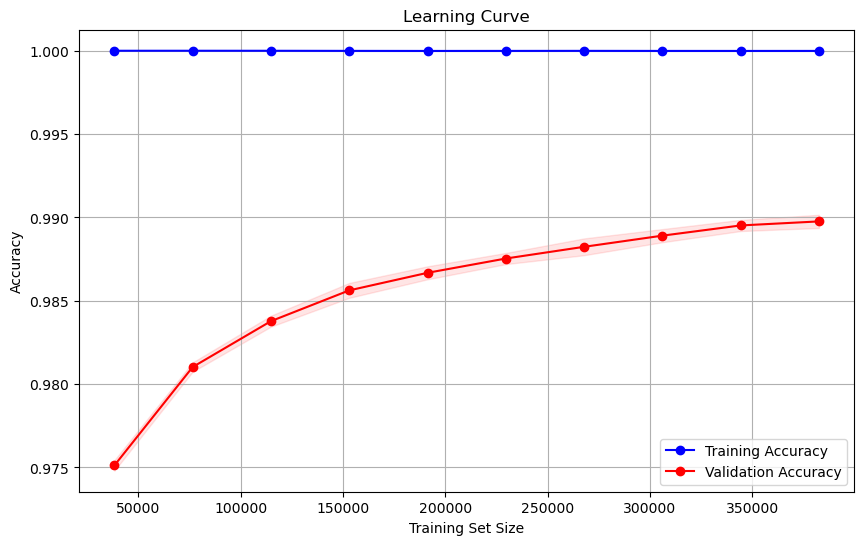

In [10]:
# Define the training set sizes for the learning curve
train_sizes = np.linspace(0.1, 1.0, 10)

# Calculate the learning curve scores
train_sizes, train_scores, test_scores = learning_curve(rf, pixels_train_scaled, labels_train, cv=5, train_sizes=train_sizes)

# Calculate the mean and standard deviation of the train and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='b')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='r')
plt.plot(train_sizes, train_scores_mean, 'o-', color='b', label='Training Accuracy')
plt.plot(train_sizes, test_scores_mean, 'o-', color='r', label='Validation Accuracy')
plt.legend(loc='best')
plt.show()

AUC: 0.9994171711294719


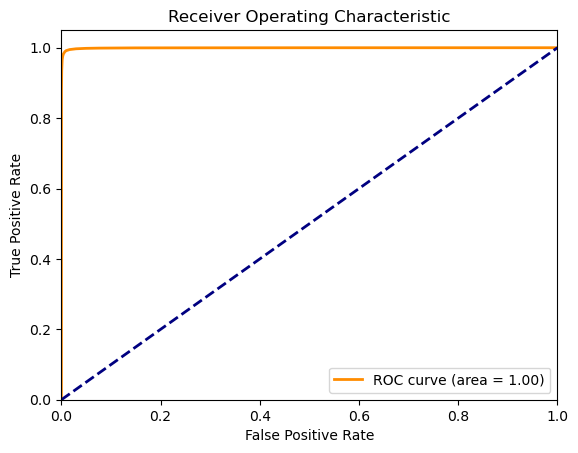

In [11]:
labels_pred_rf_prob = rf.predict_proba(pixels_test_scaled)

fpr, tpr, thresholds = roc_curve(labels_test, labels_pred_rf_prob[:, 1])

roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [12]:
# with open('random_forest_v1.pkl', 'wb') as f:
#     pickle.dump(rf, f)

# with open('minmax_scaler_v1.pkl', 'wb') as f:
#     pickle.dump(scaler, f)

In [13]:
# np.save('bland_pixels_v1.npy', bland_pixels)
# np.save('mineral_pixels_v1.npy', mineral_pixels)